In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeNet import EdgeNet, NodeNet, EdgeNODE, W1W2Net, EdgeODENet
from torch.optim import Adam

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# run only if new data is desired
ode_dim = 3
n_data = 4
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset = []
for i in range(0,len(x_train)):
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=64,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [3]:
def build_w1_w2(adjacencies, ode_dim):
    num_adj = adjacencies.size(0) // (2*(ode_dim * ode_dim))

    w_1, w_2 = adjacencies[:adjacencies.size(0) // 2], adjacencies[adjacencies.size(0) // 2:]

    Win = w_1.view(num_adj, ode_dim, ode_dim)
    Wout = w_2.view(num_adj, ode_dim, ode_dim)

    adjacencies = torch.empty(0)
    for i in range(0,Win.shape[0]):
        Ai = torch.mm(Wout[i],Win[i]).flatten()
        adjacencies = torch.cat((adjacencies, Ai))
        
    return adjacencies

In [5]:
model = EdgeODENet(n_data, ode_dim, 1)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

batch_size = 32

train_loss = []
test_loss = []

# initial test loss evaluation
with torch.no_grad():
    for data in test_loader:
        out = model(data)

        batch_size = data.batch.max().item() + 1

        adjacencies = build_w1_w2(out[:2*batch_size*ode_dim**2], ode_dim)

        loss = criterion(adjacencies, data.y)
        # print(loss.item())
        test_loss.append(loss)

        print(loss.item())

# Training loop
for epoch in range(2000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        x_T = data.x[:, :n_data].flatten()

        batch_size = data.batch.max().item() + 1

        # print(batch_size)

        adjacencies = build_w1_w2(out[:2*batch_size*ode_dim**2], ode_dim)

        loss = criterion(adjacencies, data.y)

        loss = loss + 0.01*criterion(out[2*batch_size*ode_dim**2:],x_T)
        # loss = loss + 0.0001*reg(adjacencies,0*adjacencies)
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    # print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)

            batch_size = data.batch.max().item() + 1

            x_T = data.x[:, :n_data].flatten()

            adjacencies = build_w1_w2(out[:2*batch_size*ode_dim**2], ode_dim)

            loss = criterion(adjacencies, data.y)

            loss = loss + 0.01*criterion(out[2*batch_size*ode_dim**2:],x_T)
            # print(loss.item())
            test_loss.append(loss)

            print(loss.item())

4.063796043395996
4.024038314819336
4.004101276397705
3.996145486831665
3.993685722351074
3.9917829036712646
3.9913947582244873
3.991377353668213
3.9915871620178223


KeyboardInterrupt: 

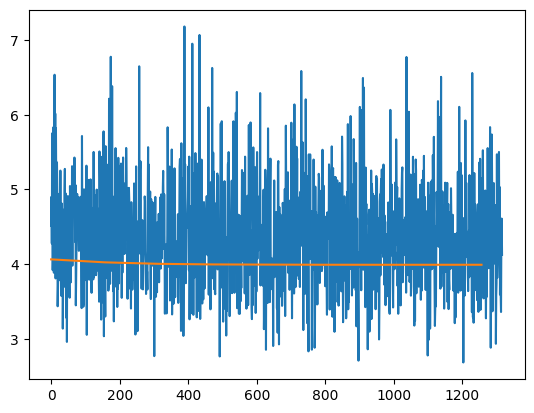

0.0
0.006
0.4288888888888889
0.6023333333333334


In [6]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(batch.edge_attr.t()[0])
    out = model(batch)
    Ahat = get_adjacency(build_w1_w2(out[:2*ode_dim**2], ode_dim)).t()
    # print(Ahat)
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)

In [4]:
model = EdgeNet(n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out.flatten(), data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            # print(loss.item())
            test_loss.append(loss)

812.3567504882812
785.8162231445312
742.6428833007812
685.2427368164062
669.784912109375
669.8889770507812
668.3834838867188
670.9932250976562
667.5720825195312
667.869873046875
668.9974975585938
668.6581420898438
667.5897827148438
670.6340942382812
667.8316650390625
667.1727294921875
667.2708129882812
666.8400268554688
667.5609741210938
669.0880737304688
668.3884887695312
667.0528564453125
667.5006103515625
668.1964111328125
668.0482788085938
666.4745483398438
668.8570556640625
668.0147094726562
669.043212890625
667.8926391601562
666.7938232421875
668.0625610351562
667.2046508789062
669.4151000976562
666.3217163085938
667.3615112304688
666.5099487304688
666.5546875
666.993896484375
668.0894775390625
667.4085083007812
667.1578369140625
666.760498046875
665.6883544921875
667.4159545898438
665.1298828125
665.5245361328125
665.9883422851562
665.79296875
667.2310791015625
666.59228515625
665.1168823242188
666.525390625
665.585693359375
665.6866455078125
668.7200317382812
666.9017333984375


KeyboardInterrupt: 

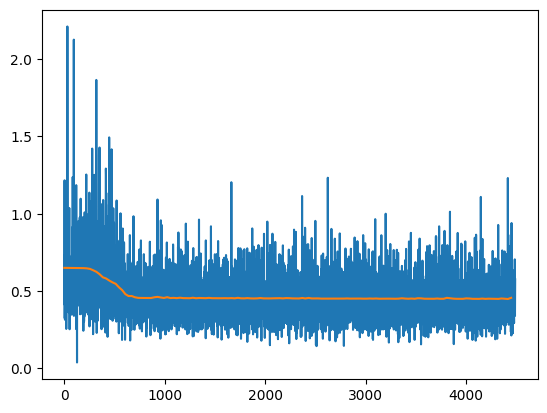

0.244
0.138
0.7175
0.50375


In [ ]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(batch.edge_attr.t()[0])
    Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)